# Recommendation Systems for Amazon Books (total 100pts + 10pts bonus)




In [ ]:
!pip install -q scikit-surprise
# !pip uninstall pandas-profiling
# !pip install pandas-profiling[notebook,html]
!pip install pyyaml==5.4.1
# !pip install autoviz
# !pip install sweetviz

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
!pip install tqdm
!pip list

Defaulting to user installation because normal site-packages is not writeable
Package                 Version
----------------------- ----------
absl-py                 0.15.0
alembic                 1.0.7
altair                  3.0.1
astunparse              1.6.3
async-generator         1.10
backcall                0.1.0
beautifulsoup4          4.7.1
biopython               1.73
bleach                  3.1.0
boto                    2.49.0
boto3                   1.9.91
botocore                1.12.91
bqplot                  0.11.5
bz2file                 0.98
cached-property         1.5.2
cachetools              4.2.4
certifi                 2018.11.29
chardet                 3.0.4
clang                   5.0
cycler                  0.10.0
dataclasses             0.8
decorator               4.3.2
defusedxml              0.5.0
docutils                0.14
elasticsearch           6.3.1
entrypoints             0.3
enum34                  1.1.6
flatbuffers             1.12
futures       

In [ ]:
import os
import pandas as pd
import numpy as np
import random
import csv
from tqdm import tqdm_notebook as tqdm
# import pandas_profiling
# from pandas_profiling import ProfileReport
# from pandas_profiling.utils.cache import cache_file
import pickle
import multiprocessing as mp
# from autoviz.AutoViz_Class import AutoViz_Class
# import sweetviz
import gc

%matplotlib inline


## ***Overview:***


In this project, you will build  recommemder systems using different approaches.

We will be using the Amazon Review data:
https://nijianmo.github.io/amazon/index.html

Note this is a fairly large dataset. We will use the Book review from `"Small" subsets for experimentation` and use `ratings only(51,311,621 ratings)` dataset, which is listed at the last section of the document. However you are required to read through the entire document before proceeding.

This is a fairely large dataset, even though we reduced the data size at various stage, you should write your program with computational cost (both spatial and temporal) in mind. 5% of grades go to efficiency in programing.

- In general when you want to discard a python object when you no longer need it (automatical garbage collection will do it also but probably not in time):
```python
del some_data_frame
```

- In general a vectorized function runs much efficiently than `for loop`:
```python
    # slow:
    total =0
    for data in dataframe["grades"]:
        if data>5: total+=data
    print(total)
```
```python
    # much faster:
    print(
        dataframe["grades"][dataframe["grades"]>5].sum()
)
```

## Task one: Data ingest (10pts)

Please download the dataset first. If you expect you are going to work on this dataset for a period of several days (which is expected), you can mount on your google drive by clicking the folder icon then Google drive icon (the third one on top after clicking the folder icon) from left menu of colab, your drive will be mounted as "/content/drive/MyDrive". Now you can use linux copy command (reference cheatsheet or search for it) to copy the file to your drive. Next time you can just copy it back when you start a new colab session. This dataset contains book reviews from Amazon, with below columns:

*  User ID
*  Book ID
*  Rating (1 to 5)
*  Date they gave the ratings(unix timestamp, google for how to convert to datetime object. For validation, 1123804800 should be converted to 2005-08-12 00:00:00)

Because of the large data size, you want to create a small dataset using first 10,000 lines (reference the spark/docker tutorial and project guide for doing this), and play with this file until your code runs ok, then you switch to the full size dataset. Let's assume the small dataset is `books10m.csv`


In [ ]:
#Mount Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Books.csv --no-check-certificate

/usr/bin/sh: wget: command not found


In [ ]:
# Load csv in to Pandas
df = pd.read_csv('books10000.csv', names = ['item_id', 'user_id', 'rating', 'timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df

,item_id,user_id,rating,timestamp
0,0001713353,A1C6M8LCIX4M6M,5.0,1970-01-14 00:10:04.800
1,0001713353,A1REUF3A1YCPHM,5.0,1970-01-13 20:55:40.800
2,0001713353,A1YRBRK2XM5D5,5.0,1970-01-13 12:17:16.800
3,0001713353,A1V8ZR5P78P4ZU,5.0,1970-01-13 11:15:21.600
4,0001713353,A2ZB06582NXCIV,5.0,1970-01-18 01:50:52.800
5,0001713353,ACPQVNRD3Z09X,5.0,1970-01-18 00:15:50.400
6,0001713353,AVP0HXC9FG790,5.0,1970-01-17 23:19:40.800
7,0001713353,A32MQTLQQN44WW,5.0,1970-01-17 21:57:36.000
8,0001713353,A13CHIJPFCEP2M,5.0,1970-01-17 20:16:48.000
9,0001713353,A324TTUBKTN73A,5.0,1970-01-17 19:46:33.600


## Task Two:  Reservoir Sampling (<font color="red">this involves some algorithms we have not covered, if feeling confused you can temporarily skip this step before the relevant lecture</font>) (15pts)


Write a function `Reservoir_Sampling`:
```python
def Reservoir_Sampling(infile_name, outfile_name, k):
    # your code
```
It takes the input file name `infile_name`, which in this case is "Books.csv" that you downloaded and sample k lines. We use the input file to mimic streaming data by read it line by line: you want to uniformly sample from the streaming data which is effectively infinitely long, you want to make sure that at any moment, for the `n` data points you received so far, you keep `k` points that are uniformly sampled from these `n` points. Note `n` is growing over time and is endlessly growing.

We will be implementing an algorithm called Reservoir Sampling to do this, which

- if `n<=k` we keep all incoming data points from the stream in a list `KEEP`;
- when a new data point that is $n^{th}$ comes, if n>k, roll a dice that gives the new data point a probability of **k/n**  to be appended to `KEEP`;
    - if the $n^{th}$ new data point is to be added to `KEEP` and if doing so would cause `len(KEEP)==k+1`, we roll another dice to randomly pick a point from `KEEP` (before appending) to throw away, each data point in `KEEP` has equal probability to be discarded.

The idea is to read the input file line by line and use "Reservoir Sampling" algorithm to keep `K` lines. When all lines from the input file is processed, write the `KEEP` to output file `outfile_name`. You will be building recommender system using this randomly sampled file.

This project asks k=10,000,000 (10million, you can use a smaller number before submission):

Following code should create the sampled file `books10m.csv' with 10m lines.
```python
Reservoir_Sampling('Books.csv', 'books10m.csv', 10000000)
```

If you don't know how to read text file line by line, consult python cheatsheet or search for it.

In [ ]:
def Reservoir_Sampling(infile_name: str, outfile_name: str, k: int):
  N = 0
  KEEP = [None] * k

  with open(infile_name) as fi:
    file_lines = fi.read().splitlines()

  for item in tqdm(file_lines):
    # skip if timestamp is smaller than 2010-01-01 00:00:00 Unix timestamp
    if item.split(',')[3].isdigit():
      if int(item.split(',')[3]) < 1262322000:
        continue

    N += 1
    if N <= k:
      KEEP[N-1] = item
    else:
      # roll a dice that gives the new data point a probability of k/n to be appended to KEEP
      dice_roll = np.random.choice([0,1], p=[1-k/N, k/N])
      if dice_roll == 1:
        # keep
        removed_data_point = random.randint(0,k-1)
        KEEP[removed_data_point] = item

  print('Writing to CSV ... ')
  gc.collect()
  with open(outfile_name,'w') as file:
      file.write('\n'.join(KEEP))

### Run code below after your function is done

You should be able to generate a new file 'books10m.csv' after running code below, it samples from "Books.csv" and has 10million lines.

In [ ]:
# DO NOT MODIFY THIS CELL
Reservoir_Sampling('Books.csv', 'books10m.csv', 10000000)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/51311621 [00:00<?, ?it/s]

Writing to CSV ... 


In [ ]:
df = pd.read_csv('books10m.csv', names = ['item_id', 'user_id', 'rating', 'timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df

,item_id,user_id,rating,timestamp
0,0001713353,A2ZB06582NXCIV,5.0,2016-10-03
1,0857208748,AY3XN01R82EAP,5.0,2012-12-29
2,0758266022,A35RNBK1KL7124,5.0,2015-08-30
3,1480094250,A1QFM3YV00P32Q,5.0,2015-02-23
4,0853642184,A2A8K6PSUQU1RD,5.0,2014-12-17
5,0470580437,A2MY2FYFLBOAGE,4.0,2013-04-09
6,B00B8FTVII,A23JMTIL4S496V,3.0,2014-05-01
7,0670921165,A32BIR6P4XY0WN,5.0,2012-05-26
8,0865680809,A2KOIT0DGIYYG6,5.0,2016-01-27
9,0001713353,A2GSWEYW6Y4OIY,4.0,2015-06-23


## Task Three: Data Exploration (15pts)

Please explore your data with appropriate plots and tables/printouts: total counts, value/counts distributions of user-item interactions, time dependency of the statistics etc. (anything related to a good insight into the data and helpful for the predictions)

In [ ]:
# Your code
profile = ProfileReport(df, title="Book Reviews", html={'style': {'full_width': True}}, minimal=True)
profile.to_file(output_file='Book Review Profiler.html')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

    Since nrows is smaller than dataset, loading random sample of 1000000 rows into pandas...
Shape of your Data Set loaded: (1000000, 4)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
Data cleaning improvement suggestions. Complete them before proceeding to ML modeling.


,Nullpercent,NuniquePercent,dtype,Nuniques,Nulls,Least num. of categories,Data cleaning improvement suggestions
item_id,0.000000,92.970000,object,9297,0,1,combine rare categories
user_id,0.000000,99.370000,object,9937,0,1,combine rare categories
rating,0.000000,0.050000,float64,5,0,0,left skewed distribution: cap or drop outliers
timestamp,0.000000,26.200000,datetime64[ns],2620,0,0,


    4 Predictors classified...
        No variables removed since no ID or low-information variables found in data set
Since Number of Rows in data 1000000 exceeds maximum, randomly sampling 1000000 rows for EDA...
Could not draw Distribution Plot


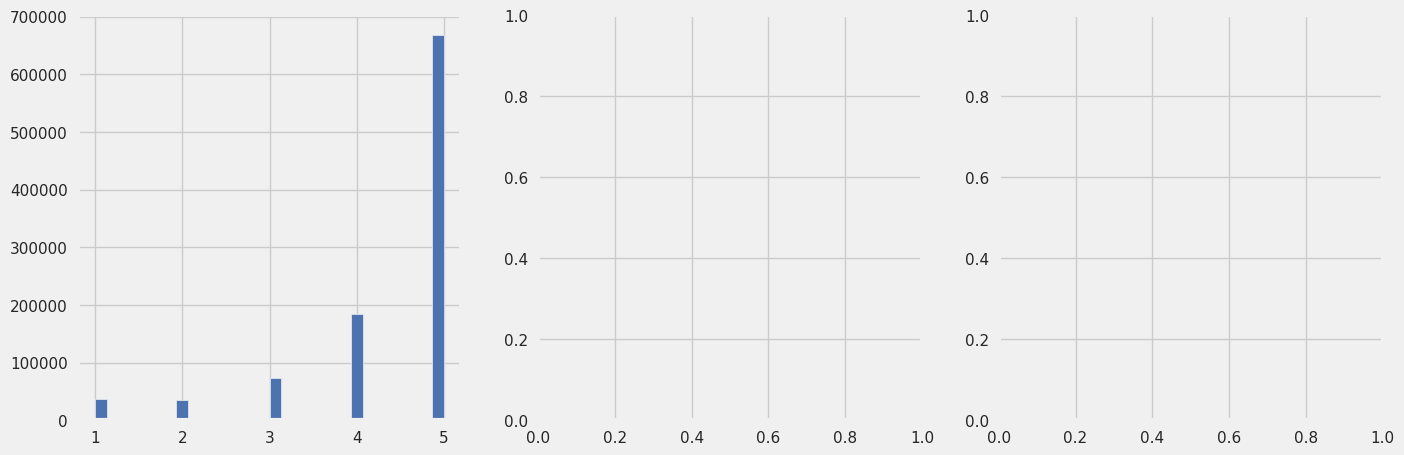

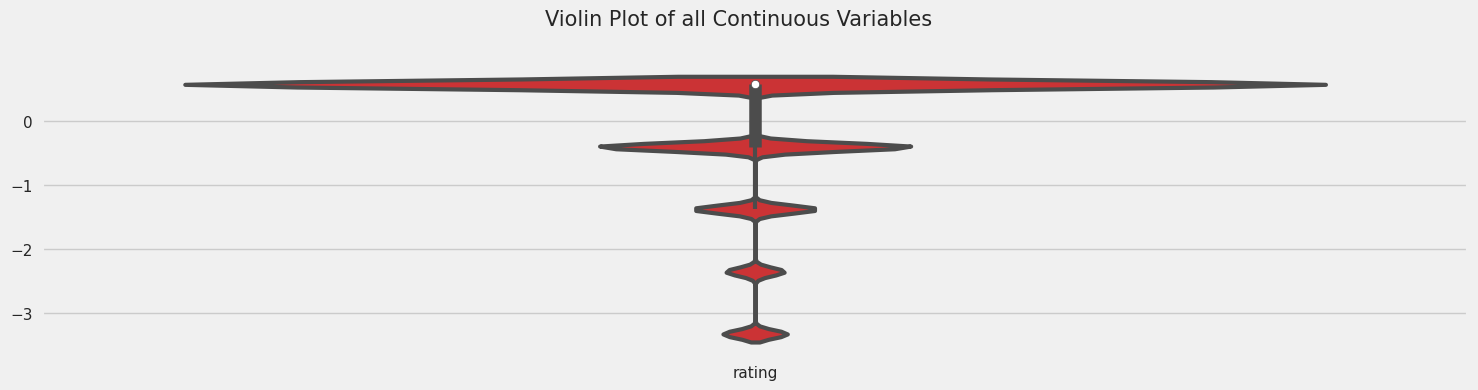

<Figure size 1500x0 with 0 Axes>

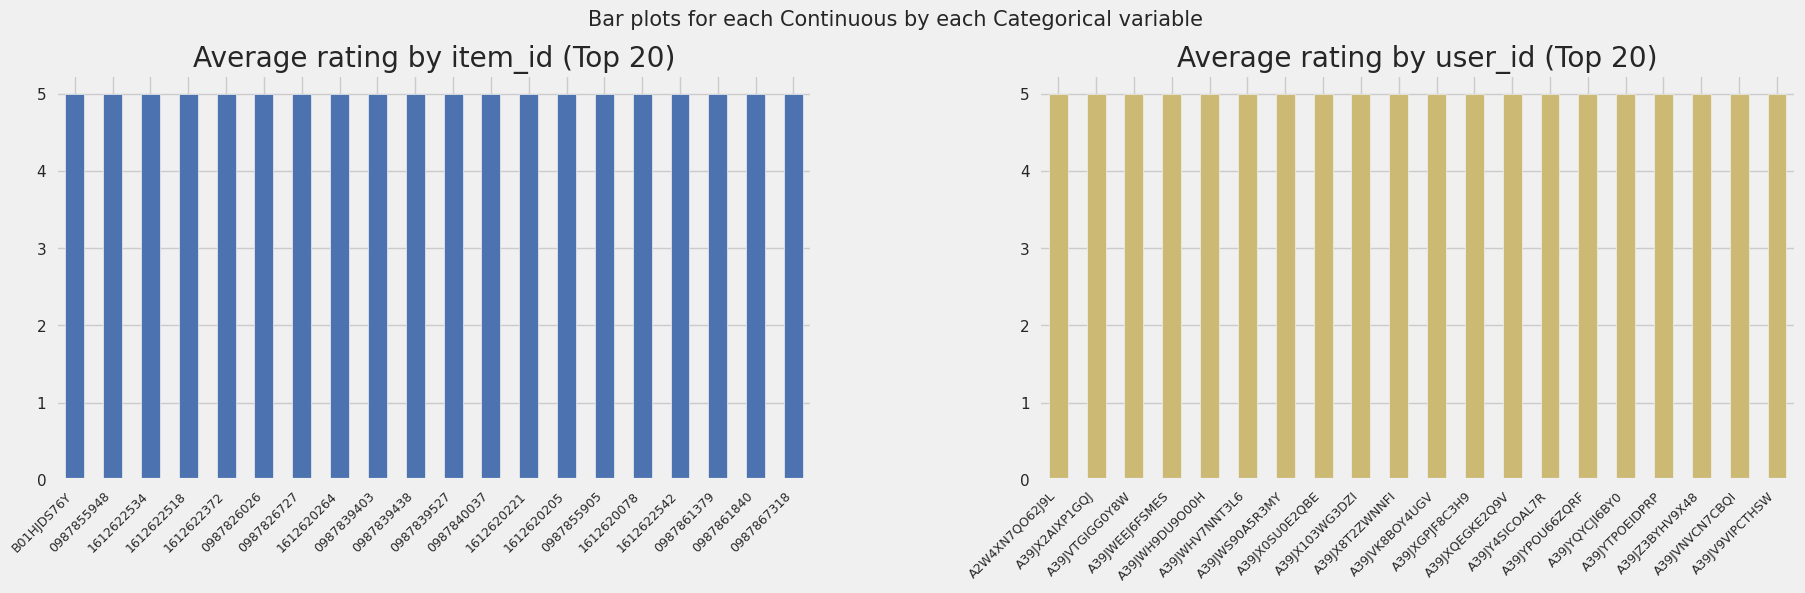

All Plots done
Time to run AutoViz = 23 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


,item_id,user_id,rating,timestamp
9747586,1519116357,A1NT1A5T0GGHZU,5.0,2015-11-24
5291393,0670020427,A1V5BXPOM03A9E,5.0,2017-03-26
5435831,0312015062,A3TFKBLNCJVMQI,5.0,2015-05-10
4859196,1484834518,A2AQMWY6CF1FIS,5.0,2013-08-30
1077580,0060755334,AT523C2XHTEP5,4.0,2014-12-19
...,...,...,...,...
6147221,1514649748,AUQC8MNMN86C7,5.0,2014-11-13
8479295,1472214196,A183TFIJAP1KA0,1.0,2016-07-08
8897492,0399551395,AV2XXZBSK82PF,4.0,2015-12-22
9782275,0986400491,AAZUKRFACQMWM,5.0,2015-10-25


In [ ]:
AutoViz_Class().AutoViz(filename="", verbose=1, dfte=df, max_rows_analyzed=1000000, lowess=False,)

                                             |          | [  0%]   00:00 -> (? left)


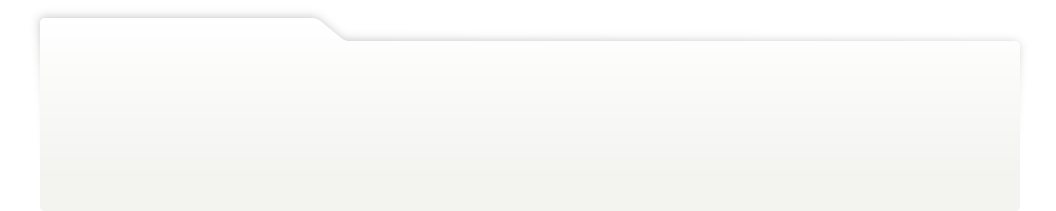
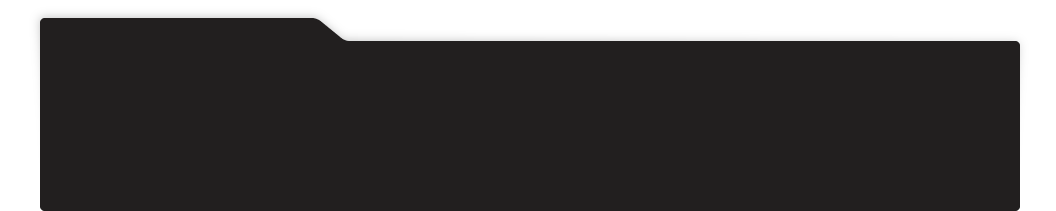
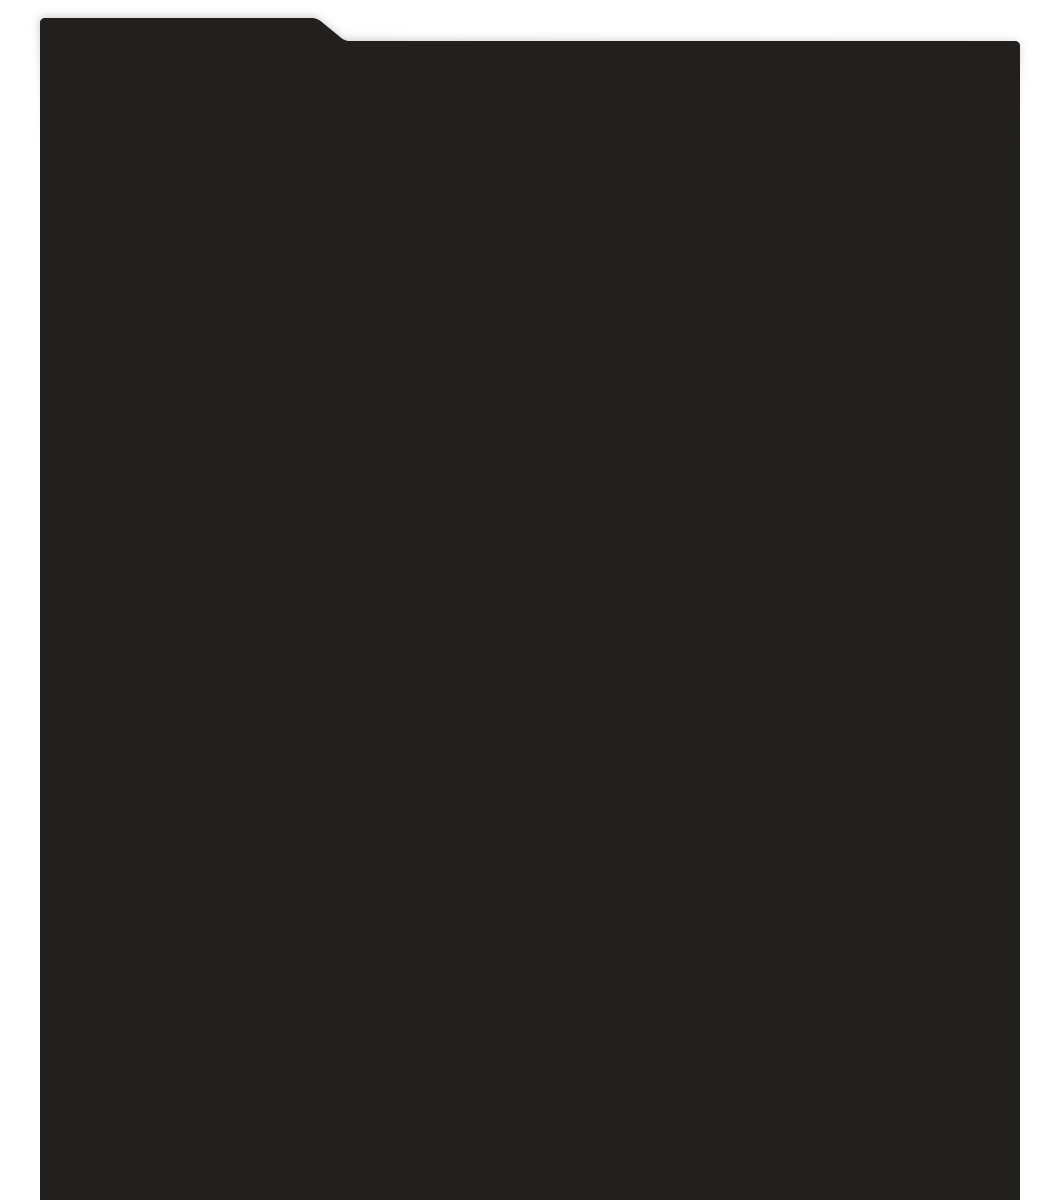
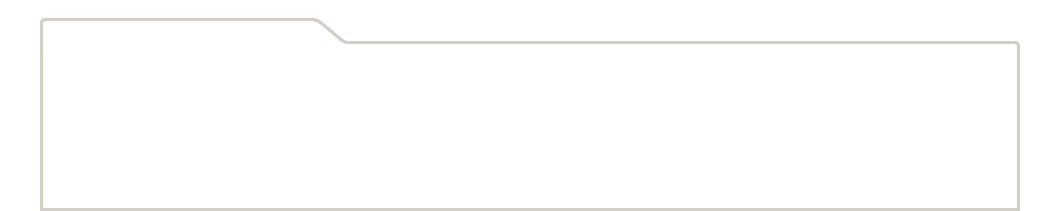
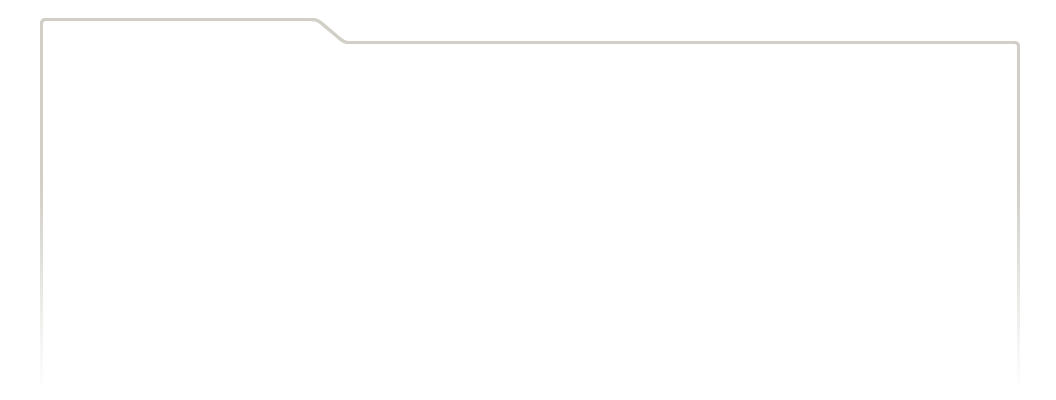
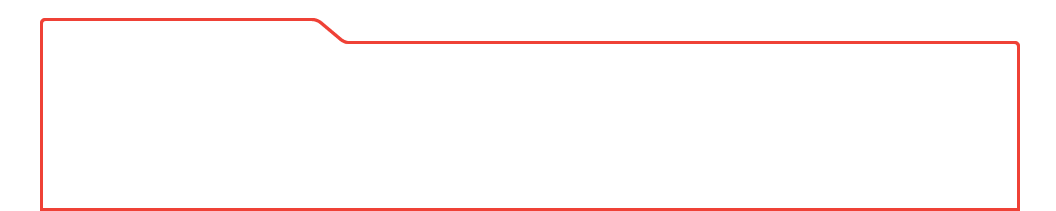
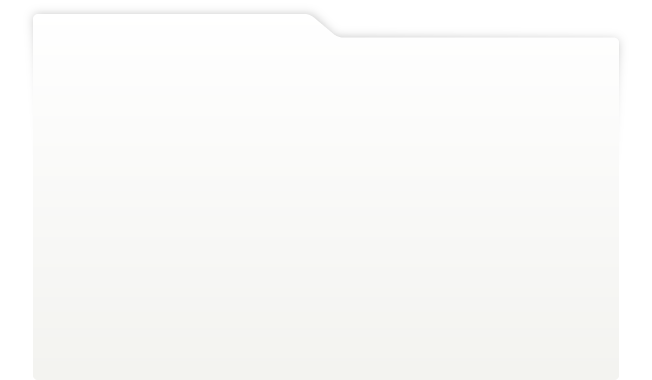
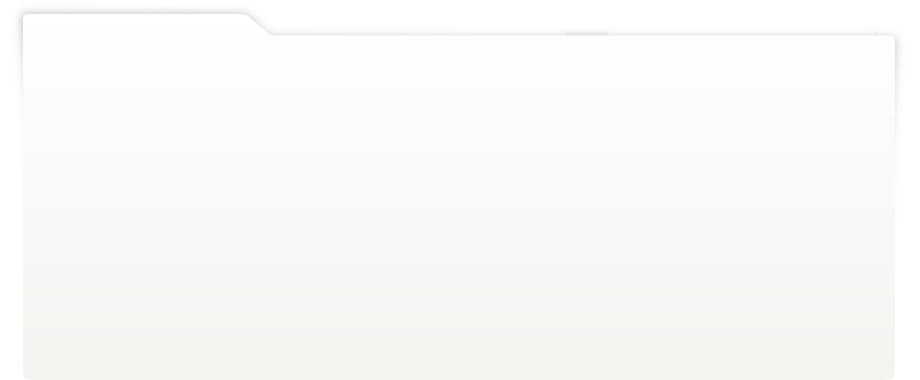
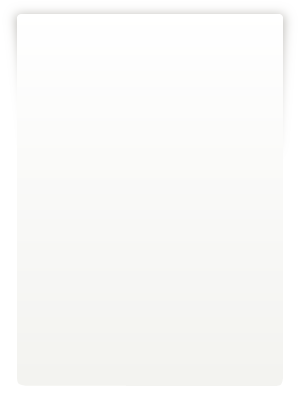
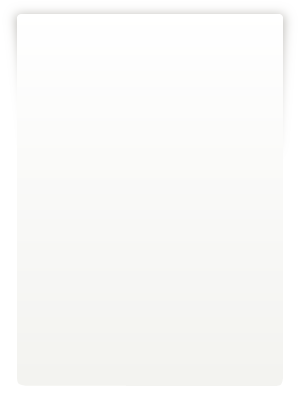
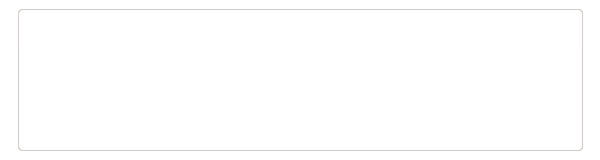
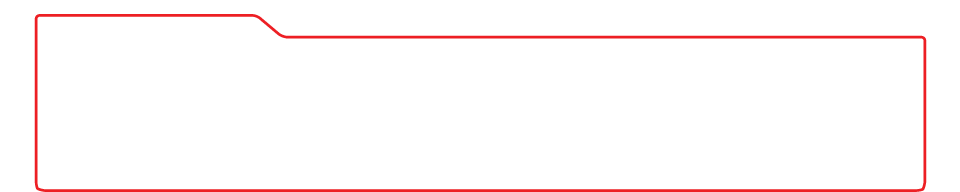
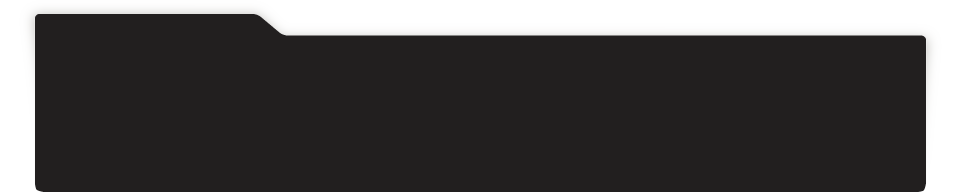
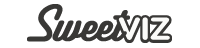
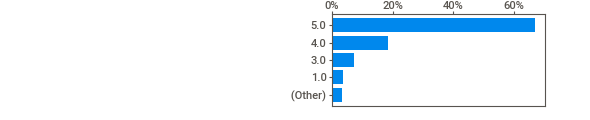
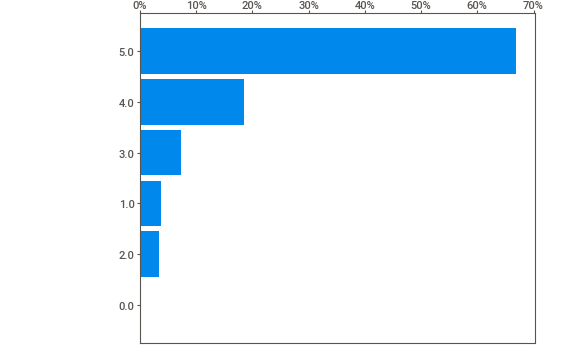
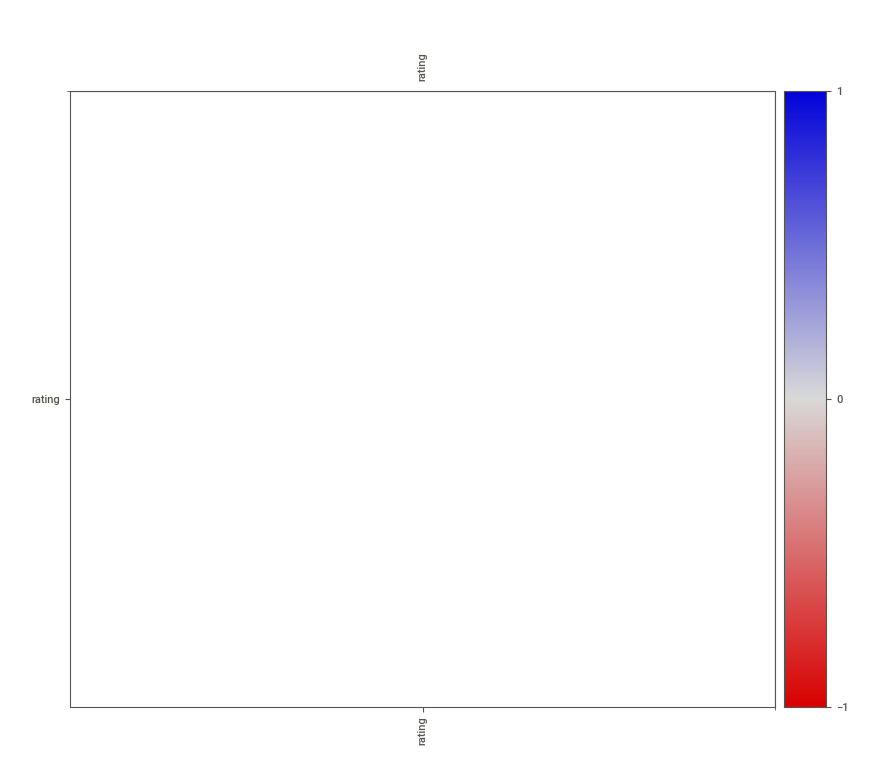
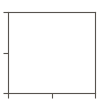

In [ ]:
sweetviz_report = sweetviz.analyze(df)
sweetviz_report.show_notebook()

## Task Four: Triming your data (15pts)

Since the dataset is pretty sparse. Please trim down the size of the data by:

- removing data before '2010-01-01 00:00:00'<font color="red" size="+2">←</font>, let's focus on more recent data

- removing books that received less than or equal to 2 user ratings

- removing users that reviewed less than or equal to `m` books, where m is 80% quantile of user ratings count (i.e., variable to consider for quantile is the total count of ratings by each user) -- we keep only the top 20% user who are active in rating books.

**Combine** the above steps into a function `trim(book_data_frame)` which takes an arguement of input dataframe and returns trimed dataframe

Call `trim()` to trim your dataset.

Print out the statistics before and after triming for the total users and books and dataframe shape.

In [ ]:
# Your code here
def trim(book_data_frame) -> pd.DataFrame:
  trimmed_df = book_data_frame.copy()
  #removing data before '2010-01-01 00:00:00'
  trimmed_df = book_data_frame[(book_data_frame['timestamp'] > '2010-01-01 00:00:00')]

  #Reduce dataset size to 10% of rows to avoid computer from crashing
  trimmed_df = trimmed_df.sample(frac=0.1, replace=False, random_state=66)

  #removing books that received less than or equal to 2 user ratings
  trimmed_df = trimmed_df.groupby('item_id').filter(lambda x: len(x) > 2)
  #removing users that reviewed less than or equal to m books, where m is 80% quantile of user ratings count (i.e., variable to consider for quantile is the total count of ratings by each user) -- we keep only the top 20% user who are active in rating books.
  ratings_quantile = trimmed_df.groupby('user_id')['rating'].count().quantile(0.8)
  user_rating_counts = trimmed_df.groupby('user_id').size().reset_index(name='counts')
  top20users = user_rating_counts[user_rating_counts['counts'] > ratings_quantile]
  trimmed_df = pd.merge(trimmed_df, top20users, on='user_id', how='left')
  trimmed_df.drop(['counts'], axis=1, inplace=True, errors='ignore')
  del book_data_frame

  return trimmed_df

In [ ]:
print(df.shape)
df.describe(include='all')

(10000000, 4)


,item_id,user_id,rating,timestamp
count,10000000,10000000,1.000000e+07,10000000
unique,1477049,5221295,NaN,3194
top,038568231X,A2OJW07GQRNJUT,NaN,2015-02-20 00:00:00
freq,12554,2089,NaN,16487
first,NaN,NaN,NaN,2010-01-02 00:00:00
last,NaN,NaN,NaN,2018-10-01 00:00:00
mean,NaN,NaN,4.413436e+00,NaN
std,NaN,NaN,1.024554e+00,NaN
min,NaN,NaN,1.000000e+00,NaN
25%,NaN,NaN,4.000000e+00,NaN


In [ ]:
trimmed_df = trim(df)
print(trimmed_df.shape)
trimmed_df.describe(include='all')

(601924, 4)


,item_id,user_id,rating,timestamp
count,601924,601924,601924.000000,601924
unique,77578,512142,NaN,3186
top,038568231X,A2F6N60Z96CAJI,NaN,2015-02-20 00:00:00
freq,1243,92,NaN,1324
first,NaN,NaN,NaN,2010-01-02 00:00:00
last,NaN,NaN,NaN,2018-09-25 00:00:00
mean,NaN,NaN,4.409364,NaN
std,NaN,NaN,1.011445,NaN
min,NaN,NaN,1.000000,NaN
25%,NaN,NaN,4.000000,NaN


In [ ]:
del df
import gc
gc.collect()

57

In [ ]:
trimmed_df.to_csv('trimmed_books.csv')

In [ ]:
trimmed_df = pd.read_csv('trimmed_books.csv')

## Task Five: fit the model using the data. (20pts)

You should prepare your data for surprise library. Check document [here](https://surprise.readthedocs.io/en/stable/getting_started.html#use-a-custom-dataset) for how to read data from pandas data frame or from text file--you need to make sure your data frame or text file follow the required format as shown in the example code.

Then you should run code below, it takes less than 30min to finish for 'books10m.csv' data set after trimming. Basically it fits the data with latent factor decomposition (SVD), that factorize the user-item matrix into latent factor matrices P and Q. The dimension (number of latent features) of P and Q is specified by `n_factors`, which defaults to 100. See `?SVD` for more options and details. The code chunk would run the SVD 3 times (called k-fold cross validation, k=3 here), each with a random split of the data into 20% for test, 80% for training, and RMS error is printed out for each of 3 runs.

Read documentation for parameters in `SVD()`: https://surprise.readthedocs.io/en/stable/matrix_factorization.html?highlight=lr_bu#surprise.prediction_algorithms.matrix_factorization.SVD.bu


You should run the code with default call to `SVD()`, as well as with  `n_factors=50, and 150)`, and combined with `lr_all=.01, 0.05 and 0.1`;  `reg_all=.01, 0.05, 0.1` (make sure you understand what these parameter mean, get a better understanding by relating these to equations in the lecture slides), respectively. Compare the RMSE and running time for each case.

In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader


from surprise import accuracy
from surprise.model_selection import KFold

In [ ]:
!python --version

Python 2.7.5


In [ ]:
trimmed_df = pd.read_csv('trimmed_books.csv')

In [ ]:
# Your code to prepare data
# Load the dataset

# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(trimmed_df[["user_id", "item_id", "rating"]], reader)

#### Run code chunk below as is after data is loaded.

In [ ]:
# define a cross-validation iterator
kf = KFold(n_splits=3)

algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.9833
RMSE: 0.9812
RMSE: 0.9889


Output example (yours may look differently):
```
RMSE: 0.8948
RMSE: 0.8936
RMSE: 0.8968
```

#### Copy code chunk above and use different parameters for `SVD` call, then rerun.

In [ ]:
n_factors_options = [50, 100, 150, 250]
reg_all_options = [0.01, 0.05, 0.1]
lr_all_options = [0.01, 0.05, 0.1]
kf = KFold(n_splits=3)

best_algo = None
best_rmse = 100
best_trainset = None

for n_factor in n_factors_options:
  for reg_all in reg_all_options:
    for lr_all in lr_all_options:
      print(f"n_factors: {n_factor}, reg_all: {reg_all}, lr_all: {lr_all}")
      gc.collect()

      for trainset, testset in kf.split(data):

        test_algo = SVD(n_factors=n_factor, reg_all=reg_all, lr_all=lr_all)
        # train and test algorithm.
        test_algo.fit(trainset)
        predictions_test = test_algo.test(testset)

        # Compute and print Root Mean Squared Error
        temp_rmse = accuracy.rmse(predictions_test, verbose=True)

        if temp_rmse < best_rmse:
          print(f'Best RMSE was {best_rmse}. New best RMSE {temp_rmse}')
          best_rmse = temp_rmse
          best_algo = test_algo
          best_trainset = trainset

n_factors: 50, reg_all: 0.01, lr_all: 0.01
RMSE: 0.9836
Best RMSE was 100. New best RMSE 0.9836300980153923
RMSE: 0.9830
Best RMSE was 0.9836300980153923. New best RMSE 0.9829637646549474
RMSE: 0.9864
n_factors: 50, reg_all: 0.01, lr_all: 0.05
RMSE: 0.9890
RMSE: 0.9950
RMSE: 0.9927
n_factors: 50, reg_all: 0.01, lr_all: 0.1
RMSE: 0.9950
RMSE: 0.9950
RMSE: 0.9889
n_factors: 50, reg_all: 0.05, lr_all: 0.01
RMSE: 0.9843
RMSE: 0.9806
Best RMSE was 0.9829637646549474. New best RMSE 0.9805964512007598
RMSE: 0.9866
n_factors: 50, reg_all: 0.05, lr_all: 0.05
RMSE: 0.9911
RMSE: 0.9941
RMSE: 0.9879
n_factors: 50, reg_all: 0.05, lr_all: 0.1
RMSE: 0.9905
RMSE: 0.9919
RMSE: 0.9928
n_factors: 50, reg_all: 0.1, lr_all: 0.01
RMSE: 0.9869
RMSE: 0.9785
Best RMSE was 0.9805964512007598. New best RMSE 0.978496115686761
RMSE: 0.9844
n_factors: 50, reg_all: 0.1, lr_all: 0.05
RMSE: 0.9904
RMSE: 0.9883
RMSE: 0.9912
n_factors: 50, reg_all: 0.1, lr_all: 0.1
RMSE: 0.9935
RMSE: 0.9902
RMSE: 0.9912
n_factors: 100, 

In [ ]:
n_factors_options = [10, 25, 50, 100, 150, 250]
reg_all_options = [0.01, 0.05, 0.1]
lr_all_options = [0.01, 0.05, 0.1]
kf = KFold(n_splits=3)

best_algo = None
best_rmse = 100
best_trainset = None
best_lr = None
best_reg = None

def evaluate_performance(trainset, testset, n_factor, reg_all, lr_all):
    test_algo = SVD(n_factors=n_factor, reg_all=reg_all, lr_all=lr_all)
    test_algo.fit(trainset)
    predictions_test = test_algo.test(testset)

    temp_rmse = accuracy.rmse(predictions_test, verbose=True)
    return test_algo, temp_rmse


# Create a DataFrame to store the results
result_df = pd.DataFrame(columns=['Split Number', 'RMSE', 'Reg Term', 'Learning Rate', 'N Factors'])

for split_number, (trainset, testset) in enumerate(kf.split(data)):
    for n_factor in n_factors_options:
        for reg_all in reg_all_options:
            for lr_all in lr_all_options:
                print(f"Split: {split_number}, n_factors: {n_factor}, reg_all: {reg_all}, lr_all: {lr_all}")
                gc.collect()

                test_algo, temp_rmse = evaluate_performance(trainset = trainset,
                                                            testset = testset,
                                                            n_factor = n_factor,
                                                            reg_all = reg_all,
                                                            lr_all = lr_all)

                if temp_rmse < best_rmse:
                  print(f'Best RMSE was {best_rmse}. New best RMSE {temp_rmse}')
                  best_rmse = temp_rmse
                  best_algo = test_algo
                  best_trainset = trainset
                  best_lr = lr_all
                  best_reg = reg_all


#                 result_df = result_df.append({'Split': split_number, 'RMSE': temp_rmse, 'Reg Term': reg_all, 'Learning Rate': lr_all}, ignore_index=True)
                new_result_df = pd.DataFrame({'Split Number': [split_number],
                                              'RMSE': [temp_rmse],
                                              'Reg Term': [reg_all],
                                              'Learning Rate': [lr_all],
                                              'N Factors': [n_factor]})

                result_df = pd.concat([result_df, new_result_df], axis = 0)

print(f'Best RMSE was {best_rmse} Best lr: {best_lr} Best reg: {best_reg}')

Split: 0, n_factors: 10, reg_all: 0.01, lr_all: 0.01
RMSE: 0.9839
Best RMSE was 100. New best RMSE 0.9838529969675848
Split: 0, n_factors: 10, reg_all: 0.01, lr_all: 0.05
RMSE: 1.0034
Split: 0, n_factors: 10, reg_all: 0.01, lr_all: 0.1
RMSE: 1.0061
Split: 0, n_factors: 10, reg_all: 0.05, lr_all: 0.01
RMSE: 0.9832
Best RMSE was 0.9838529969675848. New best RMSE 0.9831949351106749
Split: 0, n_factors: 10, reg_all: 0.05, lr_all: 0.05
RMSE: 1.0006
Split: 0, n_factors: 10, reg_all: 0.05, lr_all: 0.1
RMSE: 1.0028
Split: 0, n_factors: 10, reg_all: 0.1, lr_all: 0.01
RMSE: 0.9827
Best RMSE was 0.9831949351106749. New best RMSE 0.9826659171749383
Split: 0, n_factors: 10, reg_all: 0.1, lr_all: 0.05
RMSE: 0.9984
Split: 0, n_factors: 10, reg_all: 0.1, lr_all: 0.1
RMSE: 1.0010
Split: 0, n_factors: 25, reg_all: 0.01, lr_all: 0.01
RMSE: 0.9837
Split: 0, n_factors: 25, reg_all: 0.01, lr_all: 0.05
RMSE: 0.9970
Split: 0, n_factors: 25, reg_all: 0.01, lr_all: 0.1
RMSE: 0.9978
Split: 0, n_factors: 25, reg_

RMSE: 0.9837
Split: 2, n_factors: 25, reg_all: 0.01, lr_all: 0.05
RMSE: 0.9972
Split: 2, n_factors: 25, reg_all: 0.01, lr_all: 0.1
RMSE: 0.9985
Split: 2, n_factors: 25, reg_all: 0.05, lr_all: 0.01
RMSE: 0.9832
Split: 2, n_factors: 25, reg_all: 0.05, lr_all: 0.05
RMSE: 0.9954
Split: 2, n_factors: 25, reg_all: 0.05, lr_all: 0.1
RMSE: 0.9963
Split: 2, n_factors: 25, reg_all: 0.1, lr_all: 0.01
RMSE: 0.9826
Split: 2, n_factors: 25, reg_all: 0.1, lr_all: 0.05
RMSE: 0.9940
Split: 2, n_factors: 25, reg_all: 0.1, lr_all: 0.1
RMSE: 0.9959
Split: 2, n_factors: 50, reg_all: 0.01, lr_all: 0.01
RMSE: 0.9838
Split: 2, n_factors: 50, reg_all: 0.01, lr_all: 0.05
RMSE: 0.9916
Split: 2, n_factors: 50, reg_all: 0.01, lr_all: 0.1
RMSE: 0.9923
Split: 2, n_factors: 50, reg_all: 0.05, lr_all: 0.01
RMSE: 0.9830
Split: 2, n_factors: 50, reg_all: 0.05, lr_all: 0.05
RMSE: 0.9898
Split: 2, n_factors: 50, reg_all: 0.05, lr_all: 0.1
RMSE: 0.9907
Split: 2, n_factors: 50, reg_all: 0.1, lr_all: 0.01
RMSE: 0.9826
Split:

In [ ]:
result_df.sort_values(by='RMSE', ascending = True)

,Split Number,RMSE,Reg Term,Learning Rate,N Factors
0,0,0.981972,0.10,0.05,250
0,0,0.982117,0.05,0.10,250
0,2,0.982184,0.05,0.10,250
0,2,0.982259,0.10,0.05,250
0,0,0.982420,0.10,0.01,50
0,0,0.982463,0.10,0.01,25
0,0,0.982515,0.05,0.05,250
0,0,0.982536,0.10,0.01,100
0,0,0.982556,0.10,0.01,150
0,2,0.982560,0.05,0.05,250


In [ ]:
result_df.groupby(['Split Number'])['RMSE'].mean().sort_values()

Split Number
0    0.987778
2    0.988042
1    0.989754
Name: RMSE, dtype: float64

In [ ]:
result_df.groupby(['Reg Term'])['RMSE'].mean().sort_values()

Reg Term
0.10    0.987731
0.05    0.988228
0.01    0.989615
Name: RMSE, dtype: float64

In [ ]:
result_df.groupby(['Learning Rate'])['RMSE'].mean().sort_values()

Learning Rate
0.01    0.983960
0.05    0.990362
0.10    0.991252
Name: RMSE, dtype: float64

In [ ]:
result_df.groupby(['N Factors'])['RMSE'].mean().sort_values()

N Factors
250    0.983852
150    0.984266
100    0.985516
50     0.988703
25     0.992258
10     0.996553
Name: RMSE, dtype: float64

In [ ]:
result_df.groupby(['N Factors', 'Reg Term'])['RMSE'].mean()

N Factors  Reg Term
10         0.01        0.998497
           0.05        0.996325
           0.10        0.994837
25         0.01        0.993637
           0.05        0.992017
           0.10        0.991120
50         0.01        0.989725
           0.05        0.988362
           0.10        0.988022
100        0.01        0.986128
           0.05        0.985266
           0.10        0.985153
150        0.01        0.985014
           0.05        0.983876
           0.10        0.983907
250        0.01        0.984689
           0.05        0.983521
           0.10        0.983346
Name: RMSE, dtype: float64

In [ ]:
result_df.groupby(['N Factors', 'Learning Rate'])['RMSE'].mean()

N Factors  Learning Rate
10         0.01             0.983977
           0.05             1.001491
           0.10             1.004191
25         0.01             0.983805
           0.05             0.995888
           0.10             0.997082
50         0.01             0.983717
           0.05             0.990785
           0.10             0.991607
100        0.01             0.983727
           0.05             0.986146
           0.10             0.986674
150        0.01             0.983840
           0.05             0.984349
           0.10             0.984609
250        0.01             0.984694
           0.05             0.983513
           0.10             0.983350
Name: RMSE, dtype: float64

#### Write down your observation and your explain what you see.

The best RMSE of 0.981972 was achieved by a 250 factor model with regularization term = 0.1 and learning = 0.05

Overall, the 1st split did the best. In general, smaller learning rate is better, larger regularization term is better, and larger number of factors are better.

In [ ]:
del test_algo

## Task Six: use the model for recommendation (15pts)

Use any one of the users from above trainset in the last code chunk (n_factors=150) to predict his/her book ratings. Print the top 10 books that he did not rate but would rate highest as recommended books.

You can reference document here:
https://surprise.readthedocs.io/en/stable/getting_started.html#train-on-a-whole-trainset-and-the-predict-method

Read the example code about how to do this. Please note it doesn't matter if

```python
algo = KNNBasic()
```
or
```python
algo = SVD()
```

The syntax for prediction is the same.

In [ ]:
# Get random user from training dataset
random_inner_user_id = 9
random_user_id = best_trainset.to_raw_uid(random_inner_user_id)
# Get movies that he/she did not rated
unrated_movies = [item_id for item_id in best_trainset.all_items()
                      if best_trainset.ur[random_inner_user_id][0] != item_id]

# Get top 10
top_10_recommendations = pd.DataFrame()
pred_ratings = []
pred_movies = []

for movie_id in unrated_movies:
  movie_id = best_trainset.to_raw_iid(movie_id)
  pred_rating = best_algo.predict(random_user_id, movie_id).est
  pred_ratings.append(pred_rating)
  pred_movies.append(movie_id)

top_10_recommendations['movie_ids'] = unrated_movies
top_10_recommendations['ratings'] = pred_ratings
top_10_recommendations.sort_values(by='ratings', ascending=False).head(10)

,movie_ids,ratings
66458,66458,4.878326
16466,16466,4.821670
32605,32605,4.776869
26815,26815,4.767194
55698,55698,4.754163
28760,28760,4.740114
66094,66094,4.730403
30884,30884,4.724032
55900,55900,4.723389
49503,49503,4.720621


## Task Seven: build the SVD from scratch. (15pts, including 5pts as bonus)


Reference article [here](https://albertauyeung.github.io/2017/04/23/python-matrix-factorization.html) and notebook [here](https://albertauyeung.github.io/2017/04/23/python-matrix-factorization.html) for doing SVD/matrix factorization from scratch without using surprise. You can copy his code but you must use our reservoir sampled data from Books.csv, and you can further reduce the data size to be 10% of the rows to speed up computation.

You want to play with his code first and after you understand it you put in our dataset.

You can use the train/test split function from surprise to do train/test split:
```python
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25)

# train your copied model with our data
```
<font color="red">Important Note</font>:

- This is a fairely large dataset, to avoid  crashing your computer, you want to use a smaller dataset  -- starting from the dataframe trimed after `Task Four`, randomly sample 10% rows from it, then `trim` again to discard books that receive equal to or less than 2 user ratings (after 10% resampling, some books will lose some user ratings and become `rare` books again)


- In addition, you must use sparse matrix representation to represent the utility matrix to void crashing (refer to previous lab and documentation for `csr_matrix` in `scipy.sparse`).


- You have to figure out how to convert trainset and testset objects into the data format for the MF object. You can use python's `dir()` function to see methods/attributes of trainset, testset to explore, and the best way is to read `suprise` documentation.

- Then you call the `get_rating` method in `MF` class to predict ratings from testset, then you compute RMSE using the ratings from testset as ground truth.








In [ ]:
trimmed_df.shape

(601924, 5)

In [ ]:
new_trimmed_df.shape

(60192, 5)

In [ ]:
trimmed_df = pd.read_csv('trimmed_books.csv')
new_trimmed_df = trimmed_df.sample(frac=0.1, random_state=0)
non_rare_books = new_trimmed_df.groupby('item_id').filter(lambda x: len(x) > 2)['item_id'].tolist()
new_trimmed_df[new_trimmed_df.item_id.isin(non_rare_books)]

# A reader is still needed but only the rating_scale param is required.

reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(new_trimmed_df[["user_id", "item_id", "rating"]], reader)

In [ ]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25)
from scipy.sparse import csr_matrix
from scipy.sparse import find as sparse_find

import numpy as np

class MF():

    def __init__(self, R, K, alpha, beta, iterations, samples=None):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        if samples is not None and not isinstance(samples, list):
            samples = list(samples)
        self.samples = samples

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
#         self.b = np.mean(self.R[np.where(self.R != 0.)])
        # original np.where does not work on CSR matrices, so I am using scipy.sparse.find
        self.nonzero_row_indx, self.nonzero_col_indx, self.nonzero_val = sparse_find(self.R)
        self.b = np.mean(self.nonzero_val)
#         self.b = self.R[sparse_find(self.R)[2]].mean()

        if self.samples is None:
#             # Create a list of training samples
#             self.samples = [
#                 (i, j, self.R[i, j])
#                 for i in range(self.num_users)
#                 for j in range(self.num_items)
#                 if self.R[i, j] > 0
#             ]
            #my code, which makes use of the results from scipy.sparse.find used earlier
            assert(len(self.nonzero_row_indx) == len(self.nonzero_col_indx) == len(self.nonzero_row_indx))
            self.samples = [(self.nonzero_row_indx[i],
                            self.nonzero_col_indx[i],
                            self.nonzero_val[i]) for i in range(len(self.nonzero_col_indx))]


        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in tqdm(range(self.iterations)):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

MODIFICATIONS

Since the default function provided above was not able to accomodate with csr_matrix (the `np.where()` function is not available on the csr_matrix object. I looked online and found that csr_matrix has a `.find()` function that achieves our purpose (which is to find non-zero elements or indices so we can find the average). `np.where()` returns row indices and column indices, while `find()` returns the 2 arrays of indices but also the values. Therefore, I took the average of the values returned from `find()`.

I looked at code online [CIS331_Final_Project_Amazon_Book_Review_Recommendation_Systems](https://github.com/Genghua-Chen/CIS-331-Final-Project/blob/main/CIS331_Final_Project_Amazon_Book_Review_Recommendation_Systems.ipynb). The author found that code generating `self.samples` was taking too long to run, but could easily be replaced using `all_ratings()` function from surprise. Although I did not recognize this, I think it makes sense to apply this optimization as well.

I tried to create the utility matrix using the following approach, but it took 43 minutes to run. Others said theirs were quick. I don't think my logic has any issue, so I consulted with Kenny, Bo, Rumi, and Trueman's code to see what my problem is.

Eventually, I borrowed from Kenny but made optimizations on my own that resulted in the fastest execution speed compared to all of their methods. My previous approach looped over every item and then every user, and then every rating. Needless to say, this resulted in a worst case of O(N^3), assuming that the amount of items = amount of users and every item was rated by every user.

This new approach makes clever user of `all_ratings()` method, which means only one loop is required to traverse through all ratings.

In order to improve on others' code even more, I initialized the row indices, column indices, and ratings using Numpy arrays with size predefined and data type predefined, which improved on both speed and performance.



In [ ]:
from scipy.sparse import csr_matrix
import time

start = time.perf_counter()

row_indx  = np.empty(int(trainset.n_ratings), dtype='int')
col_indx  = np.empty(int(trainset.n_ratings), dtype='int')
ratings  = np.empty(int(trainset.n_ratings), dtype='int')

counter = 0
for user_id, item_id, rating_val in trainset.all_ratings():
    row_indx[counter] = user_id
    col_indx[counter] = item_id
    ratings[counter] = rating_val
    counter += 1

# Create the sparse matrix
sparse_matrix = csr_matrix((ratings, (row_indx, col_indx)))

end = time.perf_counter()
print(end - start)
gc.collect()

sparse_matrix

0.04569924622774124


<44144x27950 sparse matrix of type '<class 'numpy.int64'>'
	with 45144 stored elements in Compressed Sparse Row format>

In [ ]:
mf = MF(sparse_matrix, K=2, alpha=0.1, beta=0.1, iterations=10, samples = None)
mf.train()

(44144, 27950) 45144 44143 27949


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:64: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10 [00:00<?, ?it/s]

Iteration: 10 ; error = 26.3761


[(0, 160.37485317842038),
 (1, 120.44640618637665),
 (2, 93.05739675734786),
 (3, 73.31247911162167),
 (4, 59.05882572209761),
 (5, 48.473304996783085),
 (6, 40.582662386175045),
 (7, 34.557180868504226),
 (8, 29.864424191905467),
 (9, 26.376083578993587)]

In [ ]:
mf10 = MF(sparse_matrix, K=10, alpha=0.1, beta=0.1, iterations=10)
mf10.train()

(44144, 27950) 45144 44143 27949


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:64: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10 [00:00<?, ?it/s]

Iteration: 10 ; error = 30.6826


[(0, 167.98166686680045),
 (1, 135.34682023079495),
 (2, 109.66325282439466),
 (3, 89.11258291411022),
 (4, 72.69841188542675),
 (5, 59.653893670768404),
 (6, 49.460420156464984),
 (7, 41.498709665682135),
 (8, 35.40091858103134),
 (9, 30.682642804926147)]

In [ ]:
mf10_2 = MF(sparse_matrix, K=10, alpha=0.01, beta=0.01, iterations=10)
mf10.train()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:64: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10 [00:00<?, ?it/s]

Iteration: 10 ; error = 30.5683


[(0, 167.97198287989187),
 (1, 135.32193805798167),
 (2, 109.64588272987636),
 (3, 88.9419264619353),
 (4, 72.48967451236281),
 (5, 59.421239344432955),
 (6, 49.21937820545643),
 (7, 41.31425400539244),
 (8, 35.20108023509643),
 (9, 30.56832117086532)]

In [ ]:
mf100 = MF(sparse_matrix, K=10, alpha=0.1, beta=0.1, iterations=100)
mf100.train()

(44144, 27950) 45144 44143 27949


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:64: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 10 ; error = 30.5465
Iteration: 20 ; error = 15.0510
Iteration: 30 ; error = 12.8902
Iteration: 40 ; error = 12.3246
Iteration: 50 ; error = 12.0025
Iteration: 60 ; error = 11.8306
Iteration: 70 ; error = 11.7655
Iteration: 80 ; error = 11.6954
Iteration: 90 ; error = 11.6392
Iteration: 100 ; error = 11.6288


[(0, 167.96689960084873),
 (1, 135.3079906327035),
 (2, 109.64772342043605),
 (3, 89.01729257897468),
 (4, 72.55294560848444),
 (5, 59.52370491554886),
 (6, 49.280454015336765),
 (7, 41.35446855302275),
 (8, 35.26291573434473),
 (9, 30.546451408602803),
 (10, 26.92578057969405),
 (11, 24.163221189313763),
 (12, 21.937418248533078),
 (13, 20.194227944467812),
 (14, 18.829609940865605),
 (15, 17.69948788704568),
 (16, 16.875969751981287),
 (17, 16.1162316243403),
 (18, 15.532967308702545),
 (19, 15.051006425688353),
 (20, 14.697940752267565),
 (21, 14.324771771742828),
 (22, 14.02428673335954),
 (23, 13.800742852051222),
 (24, 13.575081947070213),
 (25, 13.387985288202852),
 (26, 13.309682844552691),
 (27, 13.152059942916557),
 (28, 13.09775109394696),
 (29, 12.890189363470222),
 (30, 12.868289564633383),
 (31, 12.7834157077669),
 (32, 12.661119242838817),
 (33, 12.57043398170028),
 (34, 12.571770340472698),
 (35, 12.454339968241689),
 (36, 12.379013835544175),
 (37, 12.390716112510997),

In [ ]:
mf100_2 = MF(sparse_matrix, K=10, alpha=0.01, beta=0.01, iterations=100)
mf100.train()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:64: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 10 ; error = 30.7924
Iteration: 20 ; error = 15.0747
Iteration: 30 ; error = 12.9270
Iteration: 40 ; error = 12.2932
Iteration: 50 ; error = 11.9812
Iteration: 60 ; error = 11.8573
Iteration: 70 ; error = 11.7500
Iteration: 80 ; error = 11.6776
Iteration: 90 ; error = 11.6888
Iteration: 100 ; error = 11.5902


[(0, 167.99241369433352),
 (1, 135.51499787449467),
 (2, 109.84399118336835),
 (3, 89.21387106074164),
 (4, 72.76043258615566),
 (5, 59.740510727179895),
 (6, 49.509914323792174),
 (7, 41.59306039490075),
 (8, 35.518031841213634),
 (9, 30.792375460508588),
 (10, 27.10817552255302),
 (11, 24.31303160754692),
 (12, 22.088912741896667),
 (13, 20.300561269313746),
 (14, 18.96850198900091),
 (15, 17.78409737090493),
 (16, 16.912274570649824),
 (17, 16.20846532308081),
 (18, 15.61369470787909),
 (19, 15.074658464090117),
 (20, 14.63504892760734),
 (21, 14.324364947110952),
 (22, 14.02464895315255),
 (23, 13.864547275685428),
 (24, 13.6415791438707),
 (25, 13.470671408085604),
 (26, 13.289050956790335),
 (27, 13.119976292790406),
 (28, 13.057948295944179),
 (29, 12.927004572256564),
 (30, 12.85674382491871),
 (31, 12.748805463564139),
 (32, 12.669316417022175),
 (33, 12.612430573833866),
 (34, 12.518167379797626),
 (35, 12.451637696528664),
 (36, 12.451439404390692),
 (37, 12.367538292535679)

In [ ]:
mf = MF(utility_matrix, K=10, alpha=0.1, beta=0.1, iterations=10)
mf.train()

  0%|          | 0/10 [00:00<?, ?it/s]

Iteration: 10 ; error = 7.2095


[(0, 64.72183426641068),
 (1, 46.612076112522516),
 (2, 34.20696157442368),
 (3, 25.575998144162696),
 (4, 19.51188775872785),
 (5, 15.225903688824674),
 (6, 12.173444429529905),
 (7, 9.96733198847626),
 (8, 8.369050379008812),
 (9, 7.209547449993761)]

# Submission

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructor and / or from in the provided links, all of my code, report, and figures were produced by myself.</font>

## My name: Ian Liu